In [2]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import pathlib

# Old version

In [ ]:
# train_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-train/left/')
# test_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-test/left/')
# train_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-train-v4/left/')
# test_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-test-v2/left/')
train_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/augmented/usual_colors/hei-train-v1_v2/left/')
test_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/augmented/usual_colors/hei-test-v1/left/')

In [3]:
images = list(train_folder_path.glob('*/*.jpg'))
image_count = len(images)
print(image_count)

927


(128, 128)


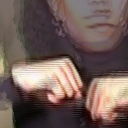

In [4]:
abitare = list(train_folder_path.glob('abitare/*'))
image = PIL.Image.open(str(abitare[0]))
print(image.size)
image

(104, 104)


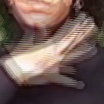

In [5]:
acqua = list(train_folder_path.glob('*acqua/*'))
image = PIL.Image.open(str(acqua[1]))
print(image.size)
image

In [6]:
images_sizes = [PIL.Image.open(image).size[0] for image in images]
images_sizes[:10]

[92, 108, 94, 108, 90, 90, 100, 100, 64, 70]

In [7]:
min(images_sizes)

40

In [8]:
video_shape = (576, 720)
video_area = video_shape[0]*video_shape[1]
images_areas = np.square(images_sizes)

In [9]:
area_ratio = np.round(images_areas/video_area, 3)
average_ratio = np.round(np.mean(area_ratio), 3)
average_ratio

0.025

In [10]:
np.round(np.mean(images_sizes))

100.0

In [12]:
train_batch_size = 32
img_height = 100
img_width = 100

In [13]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  train_folder_path,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

Found 927 files belonging to 10 classes.
Using 742 files for training.
Using 185 files for validation.


In [24]:
train_ds= tf.keras.utils.image_dataset_from_directory(
  train_folder_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

Found 927 files belonging to 10 classes.


In [14]:
class_names = train_ds.class_names

In [15]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_folder_path,
  image_size=(img_height, img_width),
  batch_size=100)

Found 79 files belonging to 10 classes.


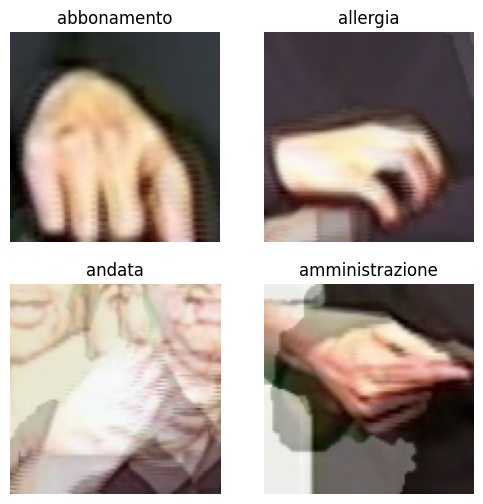

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

8.916056 254.82138


In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [18]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
num_classes = len(class_names)

In [22]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [38]:
alexnet = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu'),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [39]:
alexnet.compile(
    optimizer='sgd',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']    
)

In [ ]:
model.fit(
  train_ds,
  epochs=8,
  validation_data=val_ds
)

Epoch 1/15


d:\Documentos\Polito\Thesis\Code\sign-language-recognition\thesis-venv\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - 6s 161ms/step - loss: 1.7605 - accuracy: 0.4151 - val_loss: 0.9751 - val_accuracy: 0.6649
Epoch 2/15
24/24 [==============================] - 4s 147ms/step - loss: 0.7256 - accuracy: 0.7318 - val_loss: 0.5095 - val_accuracy: 0.7730
Epoch 3/15
24/24 [==============================] - 4s 152ms/step - loss: 0.3839 - accuracy: 0.8774 - val_loss: 0.2577 - val_accuracy: 0.9405
Epoch 4/15
24/24 [==============================] - 4s 147ms/step - loss: 0.1697 - accuracy: 0.9488 - val_loss: 0.2255 - val_accuracy: 0.9459
Epoch 5/15
24/24 [==============================] - 4s 150ms/step - loss: 0.0718 - accuracy: 0.9852 - val_loss: 0.1529 - val_accuracy: 0.9622
Epoch 6/15
24/24 [==============================] - 4s 147ms/step - loss: 0.0371 - accuracy: 0.9919 - val_loss: 0.0368 - val_accuracy: 0.9892
Epoch 7/15
24/24 [==============================] - 4s 147ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 0.9892
Epoch 8/15
24/24 

In [25]:
model.fit(
  train_ds,
  epochs=8
)

Epoch 1/8
29/29 [==============================] - 5s 148ms/step - loss: 1.6860 - accuracy: 0.4790
Epoch 2/8
29/29 [==============================] - 4s 145ms/step - loss: 0.5392 - accuracy: 0.8123
Epoch 3/8
29/29 [==============================] - 4s 145ms/step - loss: 0.1858 - accuracy: 0.9579
Epoch 4/8
29/29 [==============================] - 4s 149ms/step - loss: 0.1327 - accuracy: 0.9644
Epoch 5/8
29/29 [==============================] - 4s 146ms/step - loss: 0.0377 - accuracy: 0.9946
Epoch 6/8
29/29 [==============================] - 4s 145ms/step - loss: 0.0135 - accuracy: 0.9989
Epoch 7/8
29/29 [==============================] - 4s 144ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 8/8
29/29 [==============================] - 4s 146ms/step - loss: 0.0037 - accuracy: 1.0000


In [40]:
import math
# Define configuration parameters
start_lr = 0.005
rampup_epochs = 10
exp_decay = 0.1

# Define the scheduling function
def schedule(epoch):
  def lr(epoch, start_lr, rampup_epochs, exp_decay):
    if epoch < rampup_epochs:
      return start_lr
    else:
      return start_lr * math.exp(-exp_decay * epoch)
  return lr(epoch, start_lr, rampup_epochs, exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=True)


alexnet.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[lr_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/50


d:\Documentos\Polito\Thesis\Code\sign-language-recognition\thesis-venv\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


6/6 [==============================] - 8s 1s/step - loss: 2.3027 - accuracy: 0.0919 - val_loss: 2.3025 - val_accuracy: 0.0435 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.005.
Epoch 2/50
6/6 [==============================] - 6s 1s/step - loss: 2.3013 - accuracy: 0.0919 - val_loss: 2.3031 - val_accuracy: 0.0652 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.005.
Epoch 3/50
6/6 [==============================] - 6s 1s/step - loss: 2.3006 - accuracy: 0.1297 - val_loss: 2.3037 - val_accuracy: 0.1087 - lr: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.005.
Epoch 4/50
6/6 [==============================] - 6s 1s/step - loss: 2.2998 - accuracy: 0.1459 - val_loss: 2.3043 - val_accuracy: 0.0870 - lr: 0.0050

Epoch 5: LearningRateScheduler setting learning rate to 0.005.
Epoch 5/50
6/6 [==============================] - 7s 1s/step - loss: 2.3004 - accuracy: 0.1459 - val_loss: 2.3050 - val_accuracy: 0.0870 - lr: 0.0050

Epoc

KeyboardInterrupt: 

In [26]:
len(test_ds)

1

In [27]:
class_names

['abbonamento',
 'abitare',
 'acqua',
 'affitto',
 'allegare',
 'allergia',
 'ambulanza',
 'amministrazione',
 'ancona',
 'andata']

In [28]:
x, y = next(iter(test_ds))
predictions = np.argmax(model.predict(x), axis=-1)
labels = y

m = tf.keras.metrics.Accuracy()
m.update_state(predictions, labels)
m.result().numpy()

3/3 [==============================] - 0s 21ms/step


0.6708861

In [25]:
model.save("./saved_models/trainset_v4")

INFO:tensorflow:Assets written to: ./saved_models/trainset_v4\assets


INFO:tensorflow:Assets written to: ./saved_models/trainset_v4\assets


Label: abbonamento
Prediction: allergia


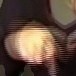




Label: abbonamento
Prediction: abbonamento


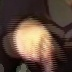




Label: abbonamento
Prediction: abbonamento


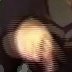




Label: abbonamento
Prediction: abbonamento


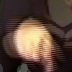




Label: abbonamento
Prediction: acqua


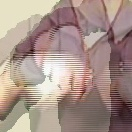




Label: abbonamento
Prediction: allegare


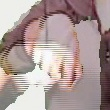




Label: abbonamento
Prediction: allergia


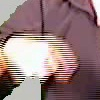




Label: abitare
Prediction: abitare


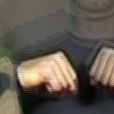




Label: abitare
Prediction: abitare


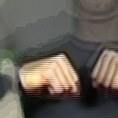




Label: abitare
Prediction: abitare


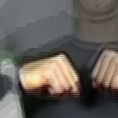




Label: abitare
Prediction: abitare


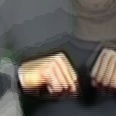




Label: abitare
Prediction: abitare


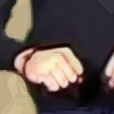




Label: abitare
Prediction: abitare


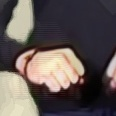




Label: abitare
Prediction: abitare


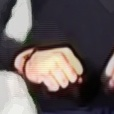




Label: abitare
Prediction: abitare


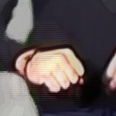




Label: acqua
Prediction: acqua


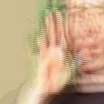




Label: acqua
Prediction: acqua


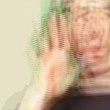




Label: acqua
Prediction: acqua


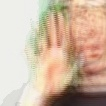




Label: acqua
Prediction: acqua


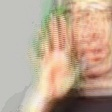




Label: acqua
Prediction: ambulanza


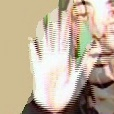




Label: acqua
Prediction: ambulanza


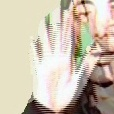




Label: acqua
Prediction: ambulanza


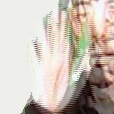




Label: acqua
Prediction: acqua


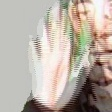




Label: affitto
Prediction: affitto


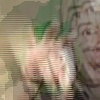




Label: affitto
Prediction: affitto


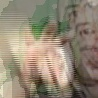




Label: affitto
Prediction: affitto


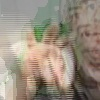




Label: affitto
Prediction: affitto


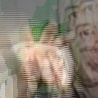




Label: affitto
Prediction: abbonamento


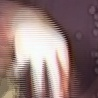




Label: affitto
Prediction: abbonamento


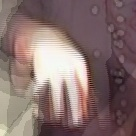




Label: affitto
Prediction: abbonamento


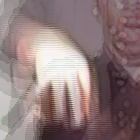




Label: affitto
Prediction: abbonamento


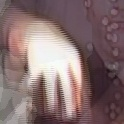




Label: allegare
Prediction: allegare


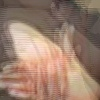




Label: allegare
Prediction: allegare


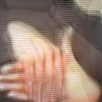




Label: allegare
Prediction: allegare


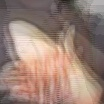




Label: allegare
Prediction: allegare


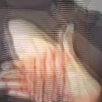




Label: allegare
Prediction: allegare


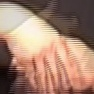




Label: allegare
Prediction: allegare


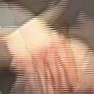




Label: allegare
Prediction: allegare


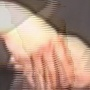




Label: allegare
Prediction: allegare


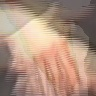




Label: allergia
Prediction: allergia


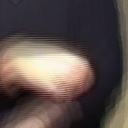




Label: allergia
Prediction: allergia


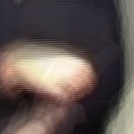




Label: allergia
Prediction: allergia


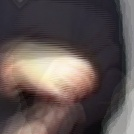




Label: allergia
Prediction: allergia


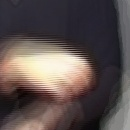




Label: allergia
Prediction: allergia


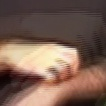




Label: allergia
Prediction: allergia


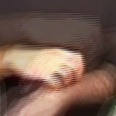




Label: allergia
Prediction: allergia


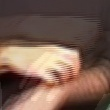




Label: allergia
Prediction: allergia


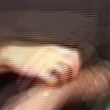




Label: ambulanza
Prediction: andata


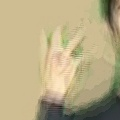




Label: ambulanza
Prediction: andata


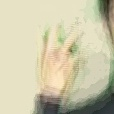




Label: ambulanza
Prediction: andata


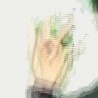




Label: ambulanza
Prediction: andata


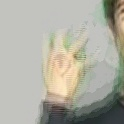




Label: ambulanza
Prediction: ambulanza


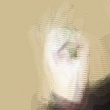




Label: ambulanza
Prediction: ambulanza


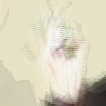




Label: ambulanza
Prediction: ambulanza


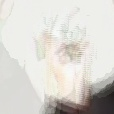




Label: ambulanza
Prediction: ambulanza


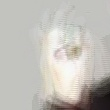




Label: amministrazione
Prediction: andata


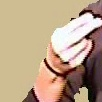




Label: amministrazione
Prediction: andata


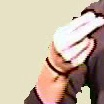




Label: amministrazione
Prediction: andata


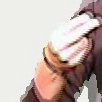




Label: amministrazione
Prediction: andata


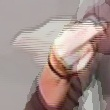




Label: amministrazione
Prediction: amministrazione


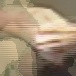




Label: amministrazione
Prediction: amministrazione


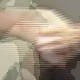




Label: amministrazione
Prediction: amministrazione


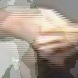




Label: amministrazione
Prediction: amministrazione


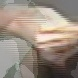




Label: ancona
Prediction: ancona


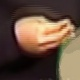




Label: ancona
Prediction: ancona


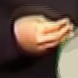




Label: ancona
Prediction: ancona


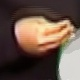




Label: ancona
Prediction: ancona


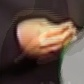




Label: ancona
Prediction: ancona


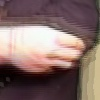




Label: ancona
Prediction: ancona


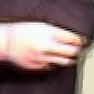




Label: ancona
Prediction: ancona


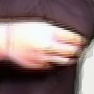




Label: ancona
Prediction: ancona


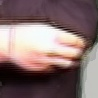




Label: andata
Prediction: amministrazione


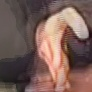




Label: andata
Prediction: amministrazione


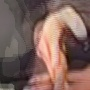




Label: andata
Prediction: amministrazione


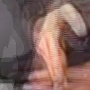




Label: andata
Prediction: amministrazione


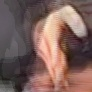




Label: andata
Prediction: allegare


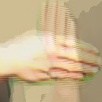




Label: andata
Prediction: ambulanza


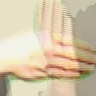




Label: andata
Prediction: andata


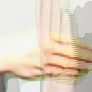




Label: andata
Prediction: ambulanza


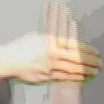

In [30]:
for path in test_folder_path.iterdir():
    for file in path.iterdir():
        print(f'Label: {path.name}')
        image = PIL.Image.open(file)
        image_array = tf.image.resize(image, [100,100])
        image_array = np.expand_dims(image_array, axis=0)
        print(f'Prediction: {class_names[int(np.argmax(model.predict(image_array, verbose=0)))]}')
        display(image)
        print('\n\n')


# New version

In [4]:
hei_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-life/augmented/usual_colors/hei-videos-v1/left/')

In [7]:
images = list(hei_folder_path.glob('*/*.jpg'))
image_count = len(images)
print(image_count)

660


(128, 128)


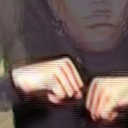

In [8]:
abitare = list(hei_folder_path.glob('abitare/*'))
image = PIL.Image.open(str(abitare[0]))
print(image.size)
image

(102, 102)


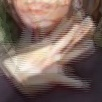

In [9]:
acqua = list(hei_folder_path.glob('*acqua/*'))
image = PIL.Image.open(str(acqua[1]))
print(image.size)
image

In [10]:
images_sizes = [PIL.Image.open(image).size[0] for image in images]
images_sizes[:10]

[128, 128, 128, 136, 104, 96, 94, 88, 116, 88]

In [11]:
min(images_sizes)

40

In [12]:
video_shape = (576, 720)
video_area = video_shape[0]*video_shape[1]
images_areas = np.square(images_sizes)

In [13]:
area_ratio = np.round(images_areas/video_area, 3)
average_ratio = np.round(np.mean(area_ratio), 3)
average_ratio

0.027

In [14]:
np.round(np.mean(images_sizes))

104.0

In [15]:
train_batch_size = 32
img_height = 100
img_width = 100

In [16]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  hei_folder_path,
  validation_split=0.3,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=train_batch_size,
  shuffle=True)

Found 660 files belonging to 17 classes.
Using 462 files for training.
Using 198 files for validation.


In [19]:
val_batches = tf.data.experimental.cardinality(val_ds)
print(val_batches)

tf.Tensor(7, shape=(), dtype=int64)


In [21]:
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

In [22]:
class_names = train_ds.class_names

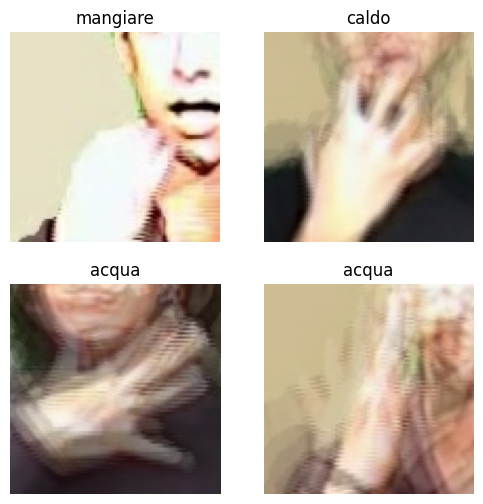

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
num_classes = len(class_names)

In [29]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [30]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [31]:
model.fit(
  train_ds,
  epochs=15,
  validation_data=val_ds
)

Epoch 1/15
15/15 [==============================] - 3s 157ms/step - loss: 2.8127 - accuracy: 0.0931 - val_loss: 2.6889 - val_accuracy: 0.1714
Epoch 2/15
15/15 [==============================] - 2s 141ms/step - loss: 2.4468 - accuracy: 0.2749 - val_loss: 2.2421 - val_accuracy: 0.3286
Epoch 3/15
15/15 [==============================] - 2s 141ms/step - loss: 1.6619 - accuracy: 0.4913 - val_loss: 1.7905 - val_accuracy: 0.4571
Epoch 4/15
15/15 [==============================] - 2s 141ms/step - loss: 1.0373 - accuracy: 0.6753 - val_loss: 1.2370 - val_accuracy: 0.6000
Epoch 5/15
15/15 [==============================] - 2s 155ms/step - loss: 0.6646 - accuracy: 0.7965 - val_loss: 1.0134 - val_accuracy: 0.6143
Epoch 6/15
15/15 [==============================] - 2s 150ms/step - loss: 0.4989 - accuracy: 0.8420 - val_loss: 0.9500 - val_accuracy: 0.6571
Epoch 7/15
15/15 [==============================] - 2s 143ms/step - loss: 0.4234 - accuracy: 0.8918 - val_loss: 0.5883 - val_accuracy: 0.7571
Epoch 

In [32]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  hei_folder_path,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=train_batch_size,
  shuffle=True)

Found 660 files belonging to 17 classes.
Using 462 files for training.


In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
num_classes = len(class_names)

In [35]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [36]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [37]:
model.fit(
  train_ds,
  epochs=8
)

Epoch 1/8
15/15 [==============================] - 3s 137ms/step - loss: 2.7563 - accuracy: 0.1320
Epoch 2/8
15/15 [==============================] - 2s 135ms/step - loss: 2.0703 - accuracy: 0.4177
Epoch 3/8
15/15 [==============================] - 2s 140ms/step - loss: 1.2619 - accuracy: 0.6255
Epoch 4/8
15/15 [==============================] - 2s 139ms/step - loss: 0.8501 - accuracy: 0.7424
Epoch 5/8
15/15 [==============================] - 2s 147ms/step - loss: 0.5121 - accuracy: 0.8636
Epoch 6/8
15/15 [==============================] - 2s 166ms/step - loss: 0.2973 - accuracy: 0.9264
Epoch 7/8
15/15 [==============================] - 2s 136ms/step - loss: 0.1812 - accuracy: 0.9610
Epoch 8/8
15/15 [==============================] - 2s 142ms/step - loss: 0.1354 - accuracy: 0.9675


In [38]:
len(test_ds)

4

In [39]:
class_names

['abitare',
 'acqua',
 'affitto',
 'banca',
 'caldo',
 'casa',
 'cibo',
 'data',
 'freddo',
 'idle',
 'interprete',
 'inviare',
 'lingua',
 'litro',
 'mangiare',
 'posta',
 'telefono']

In [40]:
accuracy = tf.keras.metrics.Accuracy()

for x_batch, y_batch in test_ds:
    predictions = np.argmax(model.predict(x_batch), axis=-1)
    
    accuracy.update_state(y_batch, predictions)

final_accuracy = accuracy.result().numpy()
print("Test accuracy:", final_accuracy)

1/1 [==============================] - 0s 49ms/step
Test accuracy: 0.8671875


In [ ]:
model.save("./saved_models/trainset_v4")

INFO:tensorflow:Assets written to: ./saved_models/trainset_v4\assets


INFO:tensorflow:Assets written to: ./saved_models/trainset_v4\assets


Label: banca
Prediction: banca


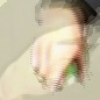




Label: litro
Prediction: litro


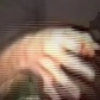




Label: inviare
Prediction: banca


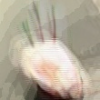




Label: affitto
Prediction: banca


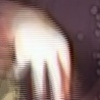




Label: freddo
Prediction: freddo


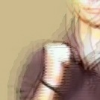




Label: idle
Prediction: idle


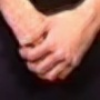




Label: affitto
Prediction: affitto


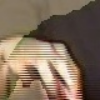




Label: freddo
Prediction: freddo


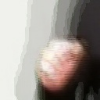




Label: data
Prediction: data


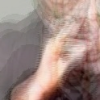




Label: interprete
Prediction: posta


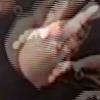




Label: interprete
Prediction: interprete


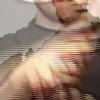




Label: freddo
Prediction: freddo


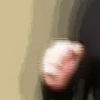




Label: lingua
Prediction: lingua


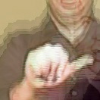




Label: litro
Prediction: banca


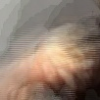




Label: posta
Prediction: posta


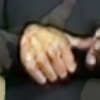




Label: affitto
Prediction: affitto


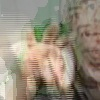




Label: lingua
Prediction: lingua


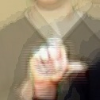




Label: data
Prediction: data


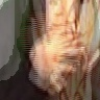




Label: data
Prediction: data


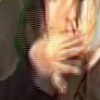




Label: idle
Prediction: idle


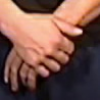




Label: caldo
Prediction: caldo


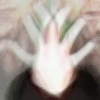




Label: interprete
Prediction: interprete


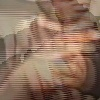




Label: banca
Prediction: banca


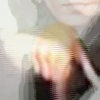




Label: lingua
Prediction: lingua


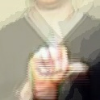




Label: idle
Prediction: idle


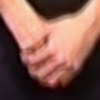




Label: posta
Prediction: posta


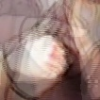




Label: inviare
Prediction: inviare


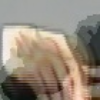




Label: affitto
Prediction: affitto


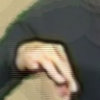




Label: interprete
Prediction: litro


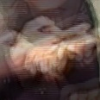




Label: mangiare
Prediction: mangiare


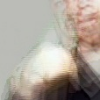




Label: caldo
Prediction: caldo


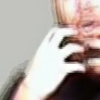




Label: acqua
Prediction: acqua


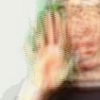




Label: mangiare
Prediction: mangiare


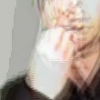




Label: telefono
Prediction: telefono


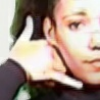




Label: mangiare
Prediction: mangiare


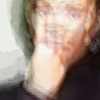




Label: caldo
Prediction: caldo


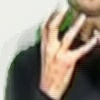




Label: inviare
Prediction: inviare


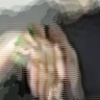




Label: abitare
Prediction: abitare


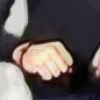




Label: litro
Prediction: litro


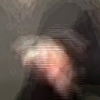




Label: interprete
Prediction: interprete


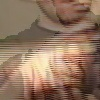




Label: acqua
Prediction: acqua


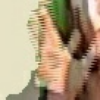




Label: data
Prediction: data


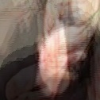




Label: posta
Prediction: posta


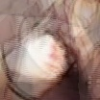




Label: banca
Prediction: banca


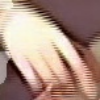




Label: mangiare
Prediction: cibo


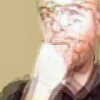




Label: acqua
Prediction: acqua


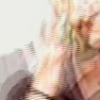




Label: affitto
Prediction: affitto


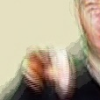




Label: caldo
Prediction: caldo


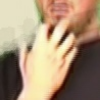




Label: casa
Prediction: casa


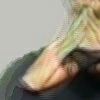




Label: casa
Prediction: casa


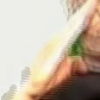




Label: telefono
Prediction: telefono


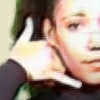




Label: telefono
Prediction: telefono


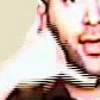




Label: inviare
Prediction: banca


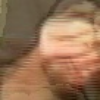




Label: inviare
Prediction: banca


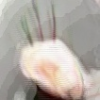




Label: interprete
Prediction: interprete


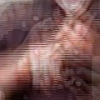




Label: litro
Prediction: litro


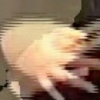




Label: cibo
Prediction: cibo


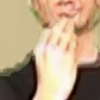




Label: interprete
Prediction: interprete


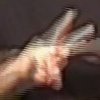




Label: posta
Prediction: posta


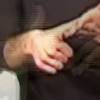




Label: lingua
Prediction: lingua


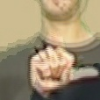




Label: lingua
Prediction: lingua


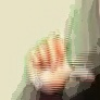




Label: inviare
Prediction: inviare


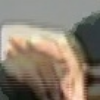




Label: acqua
Prediction: acqua


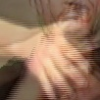




Label: telefono
Prediction: banca


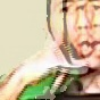




Label: mangiare
Prediction: mangiare


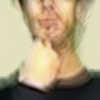




Label: acqua
Prediction: acqua


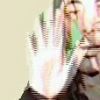




Label: mangiare
Prediction: mangiare


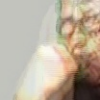




Label: casa
Prediction: casa


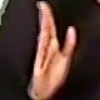




Label: abitare
Prediction: abitare


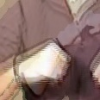




Label: acqua
Prediction: acqua


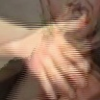




Label: litro
Prediction: affitto


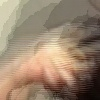




Label: acqua
Prediction: acqua


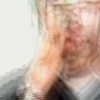




Label: inviare
Prediction: affitto


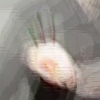




Label: interprete
Prediction: posta


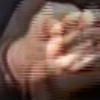




Label: idle
Prediction: idle


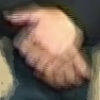




Label: inviare
Prediction: inviare


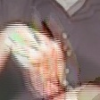




Label: lingua
Prediction: lingua


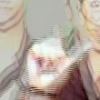




Label: posta
Prediction: posta


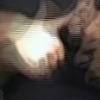




Label: freddo
Prediction: freddo


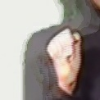




Label: idle
Prediction: idle


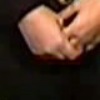




Label: interprete
Prediction: litro


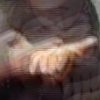




Label: banca
Prediction: banca


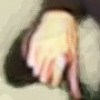




Label: affitto
Prediction: affitto


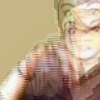




Label: freddo
Prediction: freddo


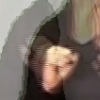




Label: freddo
Prediction: freddo


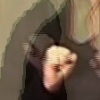




Label: acqua
Prediction: acqua


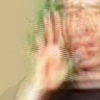




Label: lingua
Prediction: lingua


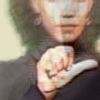




Label: idle
Prediction: idle


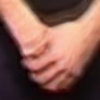




Label: interprete
Prediction: posta


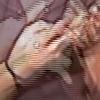




Label: interprete
Prediction: interprete


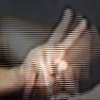




Label: data
Prediction: data


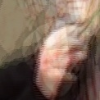




Label: posta
Prediction: posta


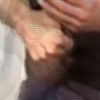




Label: data
Prediction: data


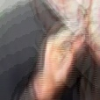




Label: data
Prediction: data


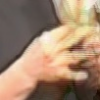




Label: posta
Prediction: posta


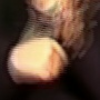




Label: acqua
Prediction: acqua


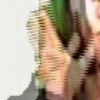




Label: affitto
Prediction: affitto


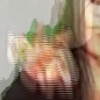




Label: affitto
Prediction: affitto


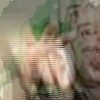




Label: idle
Prediction: idle


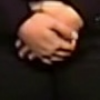




Label: abitare
Prediction: abitare


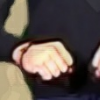




Label: lingua
Prediction: lingua


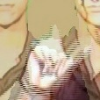




Label: caldo
Prediction: caldo


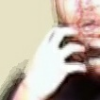




Label: posta
Prediction: posta


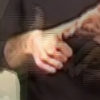




Label: idle
Prediction: idle


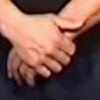




Label: litro
Prediction: litro


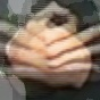




Label: interprete
Prediction: interprete


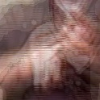




Label: banca
Prediction: banca


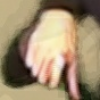




Label: caldo
Prediction: caldo


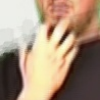




Label: inviare
Prediction: affitto


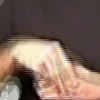




Label: abitare
Prediction: abitare


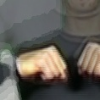




Label: affitto
Prediction: affitto


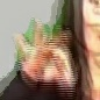




Label: cibo
Prediction: cibo


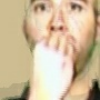




Label: cibo
Prediction: mangiare


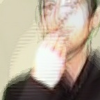




Label: casa
Prediction: casa


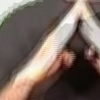




Label: cibo
Prediction: cibo


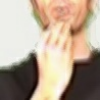




Label: abitare
Prediction: abitare


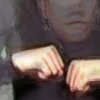




Label: freddo
Prediction: freddo


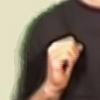




Label: lingua
Prediction: lingua


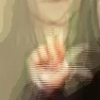




Label: inviare
Prediction: inviare


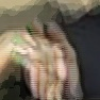




Label: banca
Prediction: banca


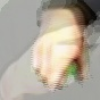




Label: acqua
Prediction: acqua


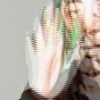




Label: lingua
Prediction: lingua


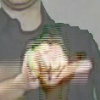




Label: freddo
Prediction: freddo


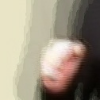




Label: acqua
Prediction: acqua


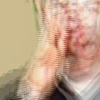




Label: data
Prediction: data


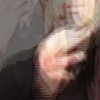




Label: acqua
Prediction: acqua


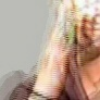




Label: lingua
Prediction: banca


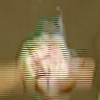




Label: inviare
Prediction: inviare


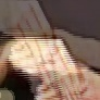

In [42]:
for images, labels in test_ds:
    # Faça as predições para o batch de imagens
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=-1)
    
    for i in range(len(images)):
        print(f'Label: {class_names[labels[i].numpy()]}')
        print(f'Prediction: {class_names[predicted_classes[i]]}')
        
        # Exiba a imagem
        img = tf.keras.preprocessing.image.array_to_img(images[i])
        display(img)
        
        print('\n\n')

# Real time test

In [15]:
import cv2
import sys
sys.path.insert(1, './hand-tracking')
import handtracker

In [21]:
cap = cv2.VideoCapture(0)
tracker = handtracker.HandTracker(hei_frame_step=2, hei_max_duration=2, hei_overlap=0)
success = True
normalization_layer = tf.keras.layers.Rescaling(1./255)

while success == True:
    success, image = cap.read()
    if success:
        tracker.tracking(image, subpixel_layout='BGR')         

        hei_left, hei_right = tracker.image_averaging(save=False)
        if len(hei_left) > 0:
            print("Check")
            hei_left = tf.image.resize(hei_left, [104,104])
            hei_left = np.expand_dims(hei_left, axis=0)
            print(f'Prediction: {class_names[int(np.argmax(model.predict(hei_left, verbose=0)))]}')

Check
Prediction: andata
Check
Prediction: andata
Check
Prediction: andata
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: amministrazione
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare
Check
Prediction: allegare


KeyboardInterrupt: 

In [22]:
cap.release()

In [26]:
class_names

['abbonamento',
 'abitare',
 'acqua',
 'affitto',
 'allegare',
 'allergia',
 'ambulanza',
 'amministrazione',
 'ancona',
 'andata']